In [1]:
# Original Matlab code https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html
#
#
# Python port of depth filling code from NYU toolbox
# Speed needs to be improved
#
# Uses 'pypardiso' solver 
#
import scipy
import skimage
import numpy as np
from pypardiso import spsolve
from PIL import Image
import os
#
# fill_depth_colorization.m
# Preprocesses the kinect depth image using a gray scale version of the
# RGB image as a weighting for the smoothing. This code is a slight
# adaptation of Anat Levin's colorization code:
#
# See: www.cs.huji.ac.il/~yweiss/Colorization/
#
# Args:
#  imgRgb - HxWx3 matrix, the rgb image for the current frame. This must
#      be between 0 and 1.
#  imgDepth - HxW matrix, the depth image for the current frame in
#       absolute (meters) space.
#  alpha - a penalty value between 0 and 1 for the current depth values.

def fill_depth_colorization(imgRgb=None, imgDepthInput=None, alpha=1):
	imgIsNoise = imgDepthInput == 0
	maxImgAbsDepth = np.max(imgDepthInput)
	imgDepth = imgDepthInput / maxImgAbsDepth
	imgDepth[imgDepth > 1] = 1
	(H, W) = imgDepth.shape
	numPix = H * W
	indsM = np.arange(numPix).reshape((W, H)).transpose()
	knownValMask = (imgIsNoise == False).astype(int)
	grayImg = skimage.color.rgb2gray(imgRgb)
	winRad = 1
	len_ = 0
	absImgNdx = 0
	len_window = (2 * winRad + 1) ** 2
	len_zeros = numPix * len_window

	cols = np.zeros(len_zeros) - 1
	rows = np.zeros(len_zeros) - 1
	vals = np.zeros(len_zeros) - 1
	gvals = np.zeros(len_window) - 1

	for j in range(W):
		for i in range(H):
			nWin = 0
			for ii in range(max(0, i - winRad), min(i + winRad + 1, H)):
				for jj in range(max(0, j - winRad), min(j + winRad + 1, W)):
					if ii == i and jj == j:
						continue

					rows[len_] = absImgNdx
					cols[len_] = indsM[ii, jj]
					gvals[nWin] = grayImg[ii, jj]

					len_ = len_ + 1
					nWin = nWin + 1

			curVal = grayImg[i, j]
			gvals[nWin] = curVal
			c_var = np.mean((gvals[:nWin + 1] - np.mean(gvals[:nWin+ 1])) ** 2)

			csig = c_var * 0.6
			mgv = np.min((gvals[:nWin] - curVal) ** 2)
			if csig < -mgv / np.log(0.01):
				csig = -mgv / np.log(0.01)

			if csig < 2e-06:
				csig = 2e-06

			gvals[:nWin] = np.exp(-(gvals[:nWin] - curVal) ** 2 / csig)
			gvals[:nWin] = gvals[:nWin] / sum(gvals[:nWin])
			vals[len_ - nWin:len_] = -gvals[:nWin]

	  		# Now the self-reference (along the diagonal).
			rows[len_] = absImgNdx
			cols[len_] = absImgNdx
			vals[len_] = 1  # sum(gvals(1:nWin))

			len_ = len_ + 1
			absImgNdx = absImgNdx + 1

	vals = vals[:len_]
	cols = cols[:len_]
	rows = rows[:len_]
	A = scipy.sparse.csr_matrix((vals, (rows, cols)), (numPix, numPix))

	rows = np.arange(0, numPix)
	cols = np.arange(0, numPix)
	vals = (knownValMask * alpha).transpose().reshape(numPix)
	G = scipy.sparse.csr_matrix((vals, (rows, cols)), (numPix, numPix))

	A = A + G
	b = np.multiply(vals.reshape(numPix), imgDepth.flatten('F'))

	#print ('Solving system..')

	new_vals = spsolve(A, b)
	new_vals = np.reshape(new_vals, (H, W), 'F')

	#print ('Done.')

	denoisedDepthImg = new_vals * maxImgAbsDepth
    
	output = denoisedDepthImg.reshape((H, W)).astype('float32')

	output = np.multiply(output, (1-knownValMask)) + imgDepthInput
    
	return output

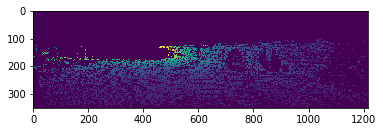

In [2]:
from matplotlib import pyplot as plt

path = "data/data_depth_selection/depth_selection/val_selection_cropped/"

imgRGB = Image.open(os.path.join(path, 'image/2011_09_26_drive_0002_sync_image_0000000005_image_02.png'))
# imgDepth = Image.open(os.path.join(path, 'groundtruth_depth/2011_09_26_drive_0002_sync_groundtruth_depth_0000000005_image_02.png'))
imgRGB = np.array(imgRGB)/255.0

def depth_read(filename = 'data/data_depth_selection/depth_selection/val_selection_cropped/groundtruth_depth/2011_09_26_drive_0002_sync_groundtruth_depth_0000000005_image_02.png'):
    # loads depth map D from png file
    # and returns it as a numpy array,
    # for details see readme.txt

    depth_png = np.array(Image.open(filename), dtype=int)
    # make sure we have a proper 16bit depth map here.. not 8bit!
    assert(np.max(depth_png) > 255)

    depth = depth_png.astype(np.float) / 256.
    depth[depth_png == 0] = -1.
    return depth
imgDepth = depth_read()
output = fill_depth_colorization(imgRGB, imgDepth)


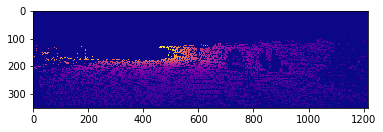

In [3]:
plt.imshow(output, cmap = 'plasma')

In [2]:
from data.dataLoader import *
val_gt = GroundTruth("data/dataset/", is_train=False, transforms=None)

In [3]:
gtl, gtr = val_gt[0]

NameError: name 'skimage' is not defined